In [2]:
import sys
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

%matplotlib inline

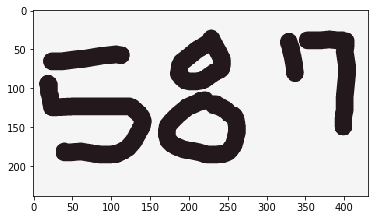

In [3]:
# 판정할 이미지

im = cv.imread('./images/587.PNG')
#im = cv.imread('./images/195.PNG')

# http://hanzratech.in/2015/02/24/handwritten-digit-recognition-using-opencv-sklearn-and-python.html
#im = cv.imread('./images/digit.jpg')

plt.imshow(im)

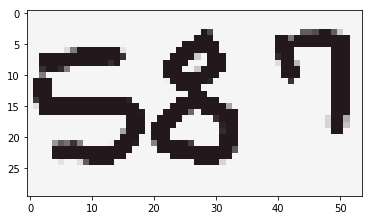

In [4]:
# 이미지를 높이 30으로 조정
# 이후 글자의 최소 높이와 너비를 정해서 roi 를 설정해보자
# https://docs.opencv.org/master/da/d6e/tutorial_py_geometric_transformations.html
# 참고하여 보간법 설정
im_h,im_w = im.shape[:2]
res_h = 30
r = res_h / float(im_h)
im_res = cv.resize(im,(int(im_w*r),int(im_h*r)), cv.INTER_AREA if r<1 else cv.INTER_LINEAR )
plt.imshow(im_res)

In [ ]:
# 여러번에 나누어 리사이즈 해보았으나 큰차이 없음
# r=0.8
# im_res = cv.resize(im,(int(im.shape[1]*r),int(im.shape[0]*r)), cv.INTER_AREA if r<1 else cv.INTER_LINEAR )
# im_res = cv.resize(im,(int(im_res.shape[1]*r),int(im_res.shape[0]*r)), cv.INTER_AREA if r<1 else cv.INTER_LINEAR )
# im_res = cv.resize(im,(int(im_res.shape[1]*r),int(im_res.shape[0]*r)), cv.INTER_AREA if r<1 else cv.INTER_LINEAR )
# im_res = cv.resize(im,(int(im_res.shape[1]*r),int(im_res.shape[0]*r)), cv.INTER_AREA if r<1 else cv.INTER_LINEAR )
# im_res = cv.resize(im,(int(im_res.shape[1]*r),int(im_res.shape[0]*r)), cv.INTER_AREA if r<1 else cv.INTER_LINEAR )
# im_res = cv.resize(im,(int(im_res.shape[1]*r),int(im_res.shape[0]*r)), cv.INTER_AREA if r<1 else cv.INTER_LINEAR )
# im_res = cv.resize(im,(int(im_res.shape[1]*r),int(im_res.shape[0]*r)), cv.INTER_AREA if r<1 else cv.INTER_LINEAR )
# im_res = cv.resize(im,(int(im_res.shape[1]*r),int(im_res.shape[0]*r)), cv.INTER_AREA if r<1 else cv.INTER_LINEAR )
# im_res = cv.resize(im,(int(im_res.shape[1]*r),int(im_res.shape[0]*r)), cv.INTER_AREA if r<1 else cv.INTER_LINEAR )
# plt.imshow(im_res)

In [ ]:
# https://docs.opencv.org/master/d9/d61/tutorial_py_morphological_ops.html
# 밝은 배경에 어두은 글씨를 쓰므로 침식/팽창을 반대로 적용
# 팽창시킬경우 축소되면서 내부 빈 공간이 사라지는 문제가 많은듯하여 제외함

#kernel = np.ones((3,3), np.uint8)
#im_res = cv.erode(im_res, kernel, iterations=1)
#im_proc = cv.morphologyEx(im_res, cv.MORPH_OPEN, np.ones((2,2), np.uint8))
#plt.imshow(im_proc)

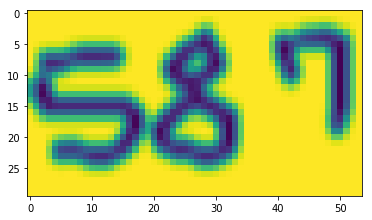

In [5]:
gray = cv.cvtColor(im_res, cv.COLOR_BGR2GRAY) # 그레이스케일로 변환하기
im_proc = cv.GaussianBlur(gray, (3, 5), 0) # 블러
plt.imshow(im_proc)

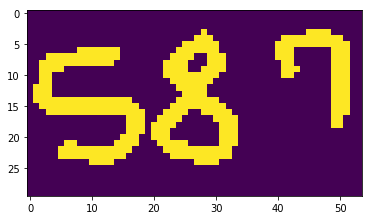

In [6]:
#하얀 배경에 쓴 글자를 인식하는 문제이므로 단순 2진화 사용
#윤곽을 따기위해 반전시킴

#thresh = cv.adaptiveThreshold(im_proc,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY_INV,11,2)
thresh = cv.threshold(im_proc, 120, 255, cv.THRESH_BINARY_INV)[1]

plt.imshow(thresh) 

contours: 3


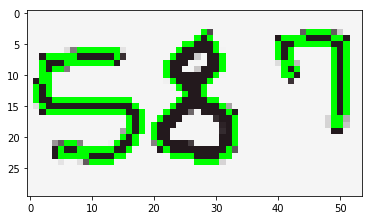

In [7]:
#im2, contours, hierarchy = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
contours = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)[1]
print('contours:',len(contours))
plt.imshow(cv.drawContours(im_res.copy(), contours, -1, (0,255,0), 1)) 

In [ ]:
# x 순으로 정렬
#rects = [ cv.boundingRect(cnt) for cnt in contours ]
#rects = sorted(rects, key=lambda x:x[0])
#rects.sort()
#단순정렬만 하는것이 아니라 잘못된 윤곽들 정리하기위해 아래로 변경

In [24]:
rects = []
im_w = im_res.shape[1]
for i, cnt in enumerate(contours):
    x, y, w, h = cv.boundingRect(cnt)
    
    # 면적이 작으면 윤곽에서 제외
    if w * h < 50: continue 
    # 면적의 70%이상을 차지하면 윤곽에서 제외
    if w * h > im_w * res_h * 0.7: continue 
    rects.append((x, y, w, h))
    
    #현재는 1줄로 입력받으므로 여러줄인경우는 검토하지 않음
    #여러줄인경우 줄에따른 인덱스도 필요함
    #y2 = round(y / 10) * 10 # Y좌표 맞추기
    #index = y2 * im_w  + x
    #rects.append((index, x, y, w, h))

# x를 기준으로 정렬
rects = sorted(rects, key=lambda x:x[0]) 
print('refined rects:',len(rects))

refined rects: 3


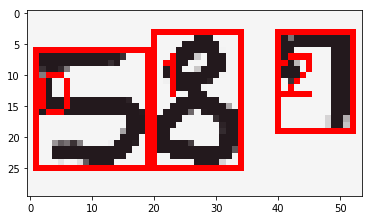

In [25]:
# 판정할 이미지 검토 용
im_tmp = im_res.copy()
for i,r in enumerate(rects):
    x,y,w,h = r
    cv.rectangle(im_tmp, (x, y), (x+w, y+h), (255,0,0), 1)
    cv.putText(im_tmp, str(i), (x,y+10), cv.FONT_HERSHEY_SIMPLEX, 0.3, (255,0,0), 1)
plt.imshow(im_tmp)

In [36]:
# 해당 영역의 이미지 데이터 추출하기 --- (※5)
X = []
im_data = []
for i, r in enumerate(rects):
    x, y, w, h = r
    
    # rect 부분 이미지 추출
    num = gray[y:y+h, x:x+w] 
    
    # 반전 : mnist를 사용하므로 이에 맞게 반전
    num = 255 - num 
    
    # 여백이 있는 정사각형 중앙으로 대상 옮기기
    ww = round((w if w > h else h) * 1.6) 
    spc = np.zeros((ww, ww))
    wy = (ww-h)//2
    wx = (ww-w)//2
    spc[wy:wy+h, wx:wx+w] = num
    
    #mnist 용으로 리사이즈
    num = cv.resize(spc, (28, 28))
    
    
    # 판정 검토용 이미지 보관
    # cv.imwrite(str(i)+"-num.PNG", num) 
    im_data.append(num)    
    
    # 데이터 정규화
    num = num.reshape(28*28)
    num = num.astype("float32") / 255
    X.append(num)

In [599]:
nlist = mnist.predict(np.array(X))
[n.argmax() for n in nlist]

[5, 8, 7]

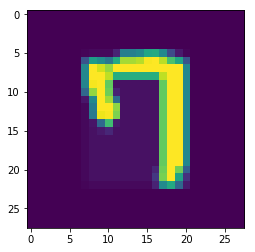

In [600]:
plt.imshow(im_data[2])

In [27]:
# 모델 불러오기
from keras.models import load_model
model = load_model('mnist_keras_cnn_model.hdf5')

/Users/mega/anaconda3/envs/ml/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [44]:
from keras import backend as K

npX=np.array(X)
# input image dimensions
img_rows, img_cols = 28, 28

if K.image_data_format() == 'channels_first':
    npX = npX.reshape(npX.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    npX = npX.reshape(npX.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [45]:
model.predict_classes(np.array(npX))

array([5, 8, 7])